# Quantum Counting (part 2)

&nbsp;

### Content:
1. [Quantum Counting](#qc)
2. [Quantum Phase Estimation](#qpe) 

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
# import basic plot tools
from qiskit.visualization import plot_histogram

# Import math Library
from math import * 

In [2]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    
    return result_counts

## 3. Quantum Counting <a id='qc'></a>

In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration. You will remember that an iteration of Grover’s algorithm, $G$, rotates the state vector by $\theta$ in the $|\omega \rangle$,$|s'\rangle$ basis:

![phase](https://learn.qiskit.org/content/v2/ch-algorithms/images/quantum_counting1.svg)

The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $|s'\rangle$.
For example, if there are not many solutions, $|s'\rangle$ will be very close to $|s' \rangle$ and $\theta$ will be very small. 
It turns out that the eigenvalues of the Grover iterator are $e^{\pm i \theta}$, and we can extract this using quantum phase estimation (QPE) to estimate the number of solutions ($M$).
 
 **In detail:**
 
 In the $|\omega \rangle$,$|s'\rangle$
 basis we can write the Grover iterator as the matrix:

 $$G = \begin{bmatrix} cos \theta & -sin \theta \\ sin \theta & cos \theta \end{bmatrix}$$
 

The matrix $G$ has eigenvectors:

  
 $$\begin{bmatrix}-i \\ 1\end{bmatrix},\begin{bmatrix}i \\ 1\end{bmatrix}$$
 

With the aforementioned eigenvalues $e^{\pm i \theta}$. 
Fortunately, we do not need to prepare our register in either of these states, the state $|s\rangle$ is in the space spanned by $|\omega \rangle$,$|s'\rangle$ and thus is a superposition of the two vectors.

 $$|s\rangle = \alpha | \omega \rangle + \beta |s'\rangle$$

As a result, the output of the QPE algorithm will be a superposition of the two phases, and when we measure the register we will obtain one of these two values! We can then use some simple maths to get our estimate of $M$.

![count](https://learn.qiskit.org/content/v2/ch-algorithms/images/quantum_counting2.svg)


<div class="alert alert-block alert-warning">

**Exercise** Find the amount of solutions in:
       
</div>

![grover](https://learn.qiskit.org/content/v2/ch-algorithms/images/grover_circuit_3qubits.png)


In [3]:
def grover_operator(n_iterations):
    from qiskit.circuit.library import Diagonal, GroverOperator
    oracle = Diagonal([1,1,1,1, 1,-1,-1,1])
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"
    return grover_it

In [4]:
from qiskit.circuit.library import QFT
qft_dagger = QFT(3, inverse=True).to_gate()
qft_dagger.label = "QFT†"

In [5]:
# Create QuantumCircuit
t = 3   # no. of counting qubits
n = 3   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations).control()
    qc.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw(fold=-1)

┌───┐                                             ┌───────┐┌─┐      
q_0: ┤ H ├───────■─────────────────────────────────────┤0      ├┤M├──────
     ├───┤       │                                     │       │└╥┘┌─┐   
q_1: ┤ H ├───────┼──────────────■──────────────────────┤1 QFT† ├─╫─┤M├───
     ├───┤       │              │                      │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼──────────────┼──────────────■───────┤2      ├─╫──╫─┤M├
     ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└───────┘ ║  ║ └╥┘
q_3: ┤ H ├┤0            ├┤0            ├┤0            ├──────────╫──╫──╫─
     ├───┤│             ││             ││             │          ║  ║  ║ 
q_4: ┤ H ├┤1 Grover$^1$ ├┤1 Grover$^2$ ├┤1 Grover$^4$ ├──────────╫──╫──╫─
     ├───┤│             ││             ││             │          ║  ║  ║ 
q_5: ┤ H ├┤2            ├┤2            ├┤2            ├──────────╫──╫──╫─
     └───┘└─────────────┘└─────────────┘└─────────────┘          ║  ║  ║ 
c: 3/════════════════════════════════════════════════════════════╩══╩══╩═
                                                                 0  1  2

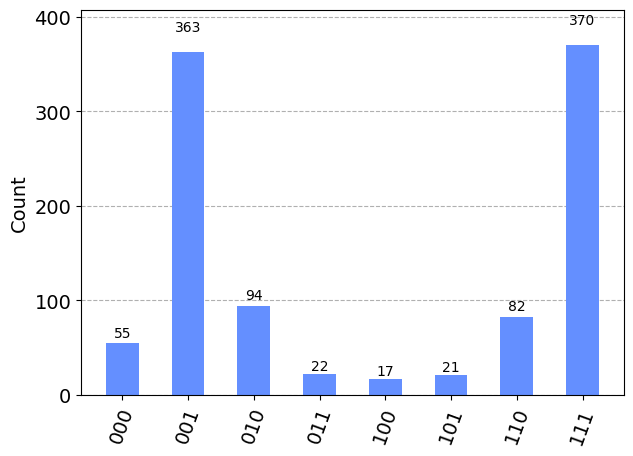

In [6]:
# Execute and see results
sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, sim)
job = sim.run(transpiled_qc)
hist = job.result().get_counts()
plot_histogram(hist)

**Refs:**
* [Quantum counting Qiskit](https://learn.qiskit.org/course/ch-algorithms/quantum-counting)

## 2. Quantum Phase Estimation<a id='qpe'></a>

&nbsp;

The phase estimation algorithm is a solution to a rather specific problem. However, similarly to the QFT and Grover's search algorithm, it turns out to be useful as a building block to several other algorithms to solve more general and important problems.

Suppose we have a unitary operator $\hat{U}$ operating on $n$-qubits, with a known eigenstate$^1$ $| \psi \rangle$ and an associated unknown eigenvalue $e^{i \theta{\psi}}$. We want to find the eigenvalue / phase, which means finding phase $\theta{\psi}$ with $m$-bits of precision.


 $$U |u \rangle = e^{i \theta_{\psi}}|u \rangle$$


We might try to prepare $n$ qubits in the state $|\theta{\psi} \rangle$ and carry out the unitary transformation $\hat{U}$ on them:


<img src="https://i.stack.imgur.com/9AFj7.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="100 px" align="center"> 


$^1$: An eigenstate is a quantum mechanical state whose wave function is an eigenvector that corresponds to a physical quantity.

<div class="alert alert-block alert-info">
    
**Question**: is there a measurement on the bits which will give us information about the phase $\phi$?

The answer is **no**: $\hat{U}$ just produces an overall phase on the state, with no observable consequences.

</div>

&nbsp;

Before we look into a more sophisticated approach to the problem, it's important to understand **phase kickback**.

### Phase kickback

&nbsp;

A key part of understanding the phase kickback is that $|\psi\rangle$ is an eigenvector of the operator $U$ with an eigenvalue of $e^{2\pi i \phi}$. In other words, $U|\psi\rangle = e^{2\pi i \phi}|\psi\rangle$, where $\phi$ is the phase that we are interested in 'kicking back'. A small example:

<img src="https://miro.medium.com/max/3600/1*DudEik8tsL5rl1aq-DUh-A.jpeg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center"> 

&nbsp;

The system's state starts simply $|0\rangle|\psi\rangle$. 

&nbsp;

**After the first Hadamard**, the Hadamard operator has converted $|0\rangle$ into $H|0\rangle = |+\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}} $. Thus, at point B, the whole system is in the state

$$\frac{|0\rangle+|1\rangle}{\sqrt{2}}|\psi\rangle = \frac{|0\rangle|\psi\rangle+|1\rangle|\psi\rangle}{\sqrt{2}}$$

&nbsp;

**After the CU** , the system is in the state 

&nbsp;

$$\frac{|0\rangle|\psi\rangle+|1\rangle U|\psi\rangle}{\sqrt{2}} = \frac{|0\rangle+e^{i \theta_{\psi}}|1\rangle}{\sqrt{2}}|\psi\rangle$$

&nbsp;

Note how the state $|\psi\rangle$ remains unchanged. This happens because applying $\hat{U}$ to $|\psi \rangle$ results in a "multiple" $e^{ i \theta{\psi}}$ of $|\psi \rangle$, which can be factored out. **This is only possible since we admit that $|\psi\rangle$ is an eigenstate of $\hat{U}$**.

&nbsp;

Now, let's consider higher powers of $U$, e.g. $U^2$. 

In this case, $|\psi\rangle$ is still an eigenvector of $U^2$.

More generally, $U^x |\psi\rangle = e^{x i \theta{\psi}}|\psi\rangle$ . 

In other words, **an eigenvector of $U$ is also an eigenvector of $U^x$; just with an eigenvalue that is raised to the power $x$**.

Thus, for a general $U^{2^k}$, after the CU, the system would be in the state

$$\frac{|0\rangle|\psi\rangle+|1\rangle U^{2^k}|\psi\rangle}{\sqrt{2}} = \frac{|0\rangle+e^{i 2^k \theta{\psi}}|1\rangle}{\sqrt{2}}|\psi\rangle$$

### Phase estimation algorithm

&nbsp;

The first part of the phase estimation algorithm consists in a paralell application of the phase kickback technique detailed above, to successive powers of $U$:

&nbsp;

<img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="600 px" align="center"> 

&nbsp;

The complete phase estimation procedure is as follows:

1. Prepare the $t$-bit control register in state $|0 \rangle$, and the target register in state $|u\rangle$ (eigenstate of $U$);

2. Perform Hadamards on the control bits.

3. Apply a controlled-$\hat{U}^{2^j}$, from the $j$th control bit onto the n target bits for each of the control q-bits in succession.

4. Perform an **inverse** Fourier transform on the $t$ control bits and measure them in the computational basis. The measured bit values $\phi_1, \cdots, \phi_n$ give an estimate of the phase $\phi \approx 0.\phi_1 \cdots \phi_n$, or $\phi \approx \frac{\phi_1}{2}+ \cdots + \frac{\phi_n}{2^n}$.

<div class="alert alert-block alert-warning">

**Exercise - Estimate the Phase of T $|1\rangle$**

&nbsp;

1. Implement the phase estimation algorithm to estimate, **to 3 bits of precision**, the phase of $T |1\rangle = e^{\frac{i \pi}{4}}|1\rangle$

Since we are looking for $\theta$ in $T |1\rangle = e^{2 i \pi \theta} |1\rangle$ we expect to find $\theta = \frac{1}{8}$

2. What is the result for eigenstate $|0 \rangle$?

&nbsp;
    
**Tip:** You can use `qc.inverse()` [qiskit.circuit.QuantumCircuit.inverse](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.inverse.html) for the qft_dagger

</div>

In [7]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-pi/float(2**(j-m)), m, j)
        qc.h(j)

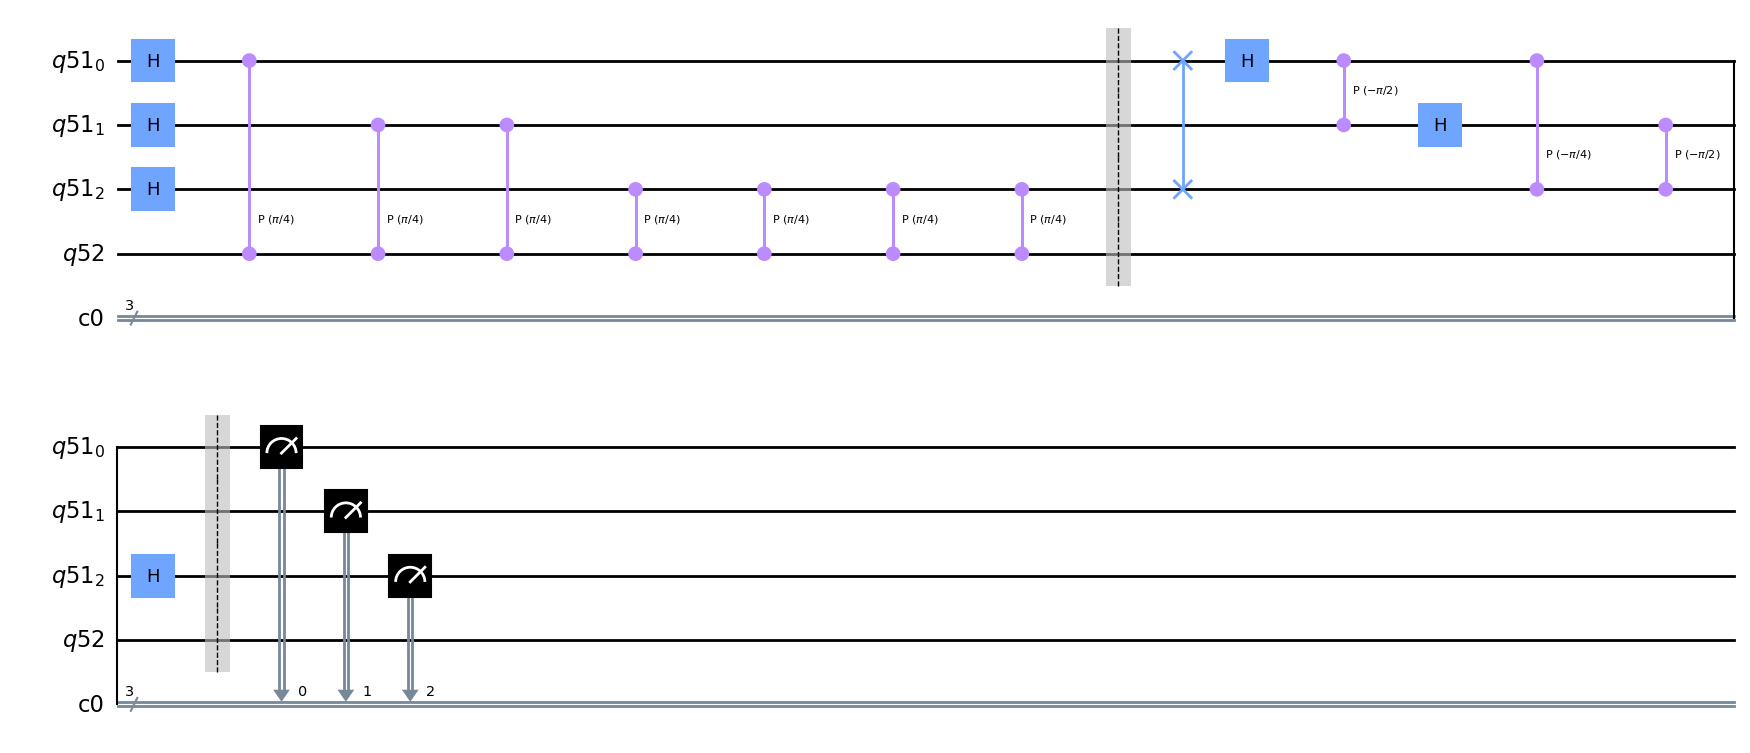

In [8]:
n=3
qctrl = QuantumRegister(n)
qtrg= QuantumRegister(1)
cr = ClassicalRegister(n)


qc = QuantumCircuit(qctrl, qtrg, cr)

qc.h(qctrl)
#qc.x(qtrg)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qc.cp(pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
# OU
#qc.crz(2*pi/4, qctrl[1], qtrg[0])
#qc.crz(2*pi/4, qctrl[1], qtrg[0])
#qc.crz(2*pi/4, qctrl[1], qtrg[0])

qr_be = []
for i in range(n):
    qr_be.append(qctrl[n-i-1])

qc.barrier()
# Apply inverse QFT
qft_dagger(qc, 3)
# Measure
qc.barrier()
for m in range(3):
    qc.measure(m,m)



qc.draw(output='mpl')

simulation: 

 {'000': 1024}


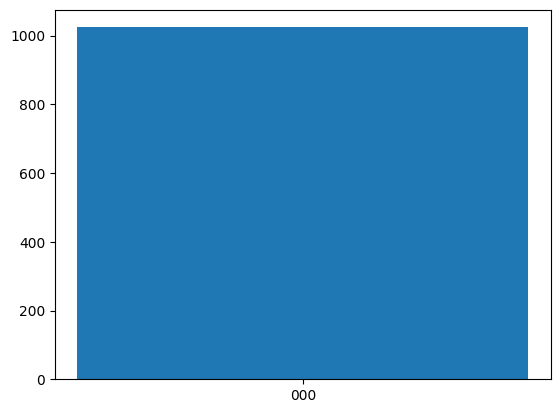

In [9]:
a = execute_locally(qc)

In [10]:
def binaryToDecimal(binary):
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    return(decimal)   

In [11]:
key = list(a.keys())[0]
r = binaryToDecimal(int(key))
theta= r/(2**n)

print(theta)

0.0


<div class="alert alert-block alert-warning">

**Exercise 2 - Implementing the phase estimation algorithm**

&nbsp;

Implement a function `phase_est(qc, qr_ctrl, qr_trg, theta, phi, lambda, n)` to create a phase estimation circuit in `qc` with `n` bits of precision, for a general single-qubit operation

&nbsp;

$$
u_3(\theta, \phi, \lambda) = 
	    \begin{pmatrix}
        \cos{(\theta/2)} & -e^{i\lambda}\sin{(\theta/2)}\\ 
        e^{i\phi}\sin{(\theta/2)} & e^{i(\lambda + \phi)}\cos{(\theta/2)}
        \end{pmatrix}
$$

&nbsp;

**Note**: The algorithm can be tested by defining an eigenstate `psi` of $u_3$ as a vector of complex coefficients. The state can be created using `qc.initialize(psi, qubit)`.

&nbsp;

</div>

In [12]:
#qc.cu(theta, phi, lambda, 0, ctrl, trg)
def phase_est(qc, qr_ctrl, qr_trg, theta, phi, lamda):
    n = len(qr_ctrl)
    
    qc.h(qr_ctrl)

    for i in range(n):
        for j in range(2**i):
            qc.cu(theta,phi,lamda, 0 , qr_ctrl[i], qr_trg[0])

    qc.barrier()

    #qr_be = []
    #for i in range(n):
    #    qr_be.append(q_ctrl[n-i-1])

    qft_dagger(qc, n)

    qc.barrier()

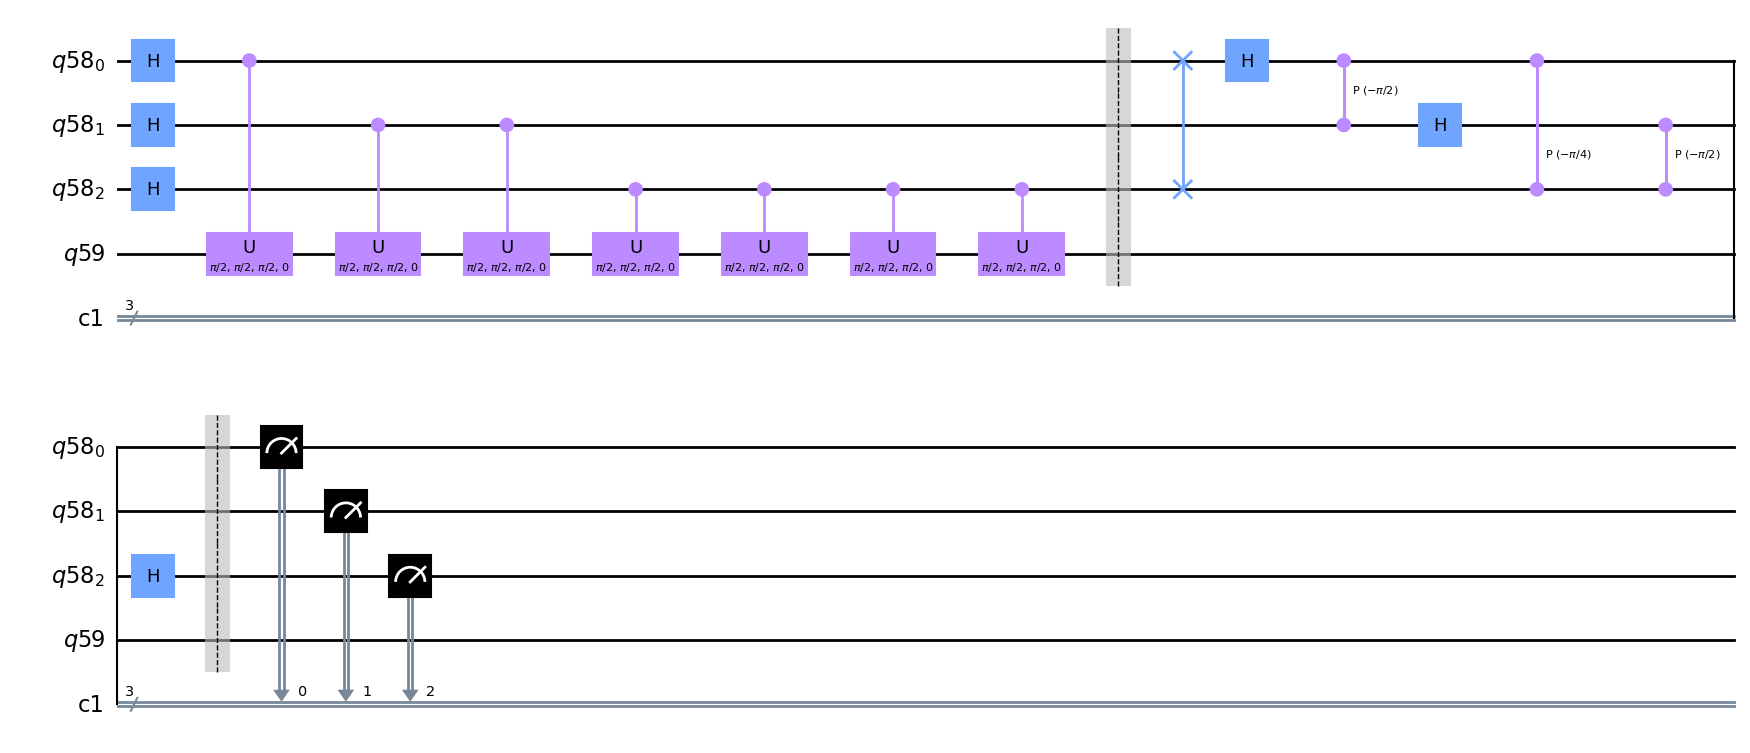

In [13]:
n=3
q_ctrl=QuantumRegister(n)
q_trg=QuantumRegister(1)
cr=ClassicalRegister(n)
qc=QuantumCircuit(q_ctrl, q_trg, cr)

phase_est(qc, q_ctrl, q_trg, pi/2, pi/2, pi/2)

qc.measure(q_ctrl, cr)
qc.draw(output='mpl')